Original Dataset Balance:
Non-Toxic comments: 1270244
Toxic comments: 534630

Toxic Subtype Counts (Before Oversampling):
severe_toxicity_bin    104636
obscene_bin            147175
threat_bin             106929
insult_bin             454539
identity_attack_bin    218552
dtype: int64

Rarest type is 'severe_toxicity_bin' with 104636 samples.

Balanced Dataset Composition:
Total samples: 777229
Non-Toxic samples: 254049
Toxic samples: 523180

COMPREHENSIVE MODEL EVALUATION
Accuracy: 0.3060
ROC AUC (micro): 0.8132
ROC AUC (macro): 0.8045

Classification Report:
                     precision    recall  f1-score   support

severe_toxicity_bin       0.79      0.36      0.50     49239
        obscene_bin       0.85      0.50      0.63     56042
         threat_bin       0.79      0.25      0.37     43400
         insult_bin       0.72      0.87      0.79     90790
identity_attack_bin       0.76      0.56      0.64     63037

          micro avg       0.76      0.56      0.65    302508
     

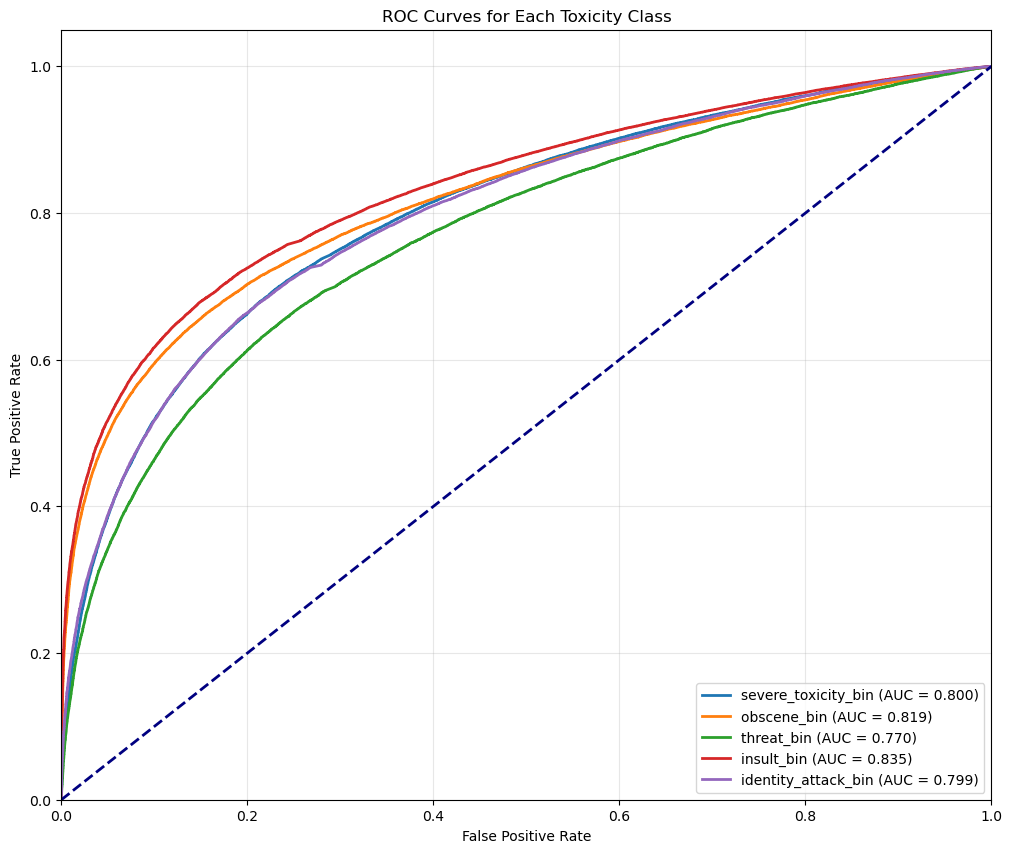

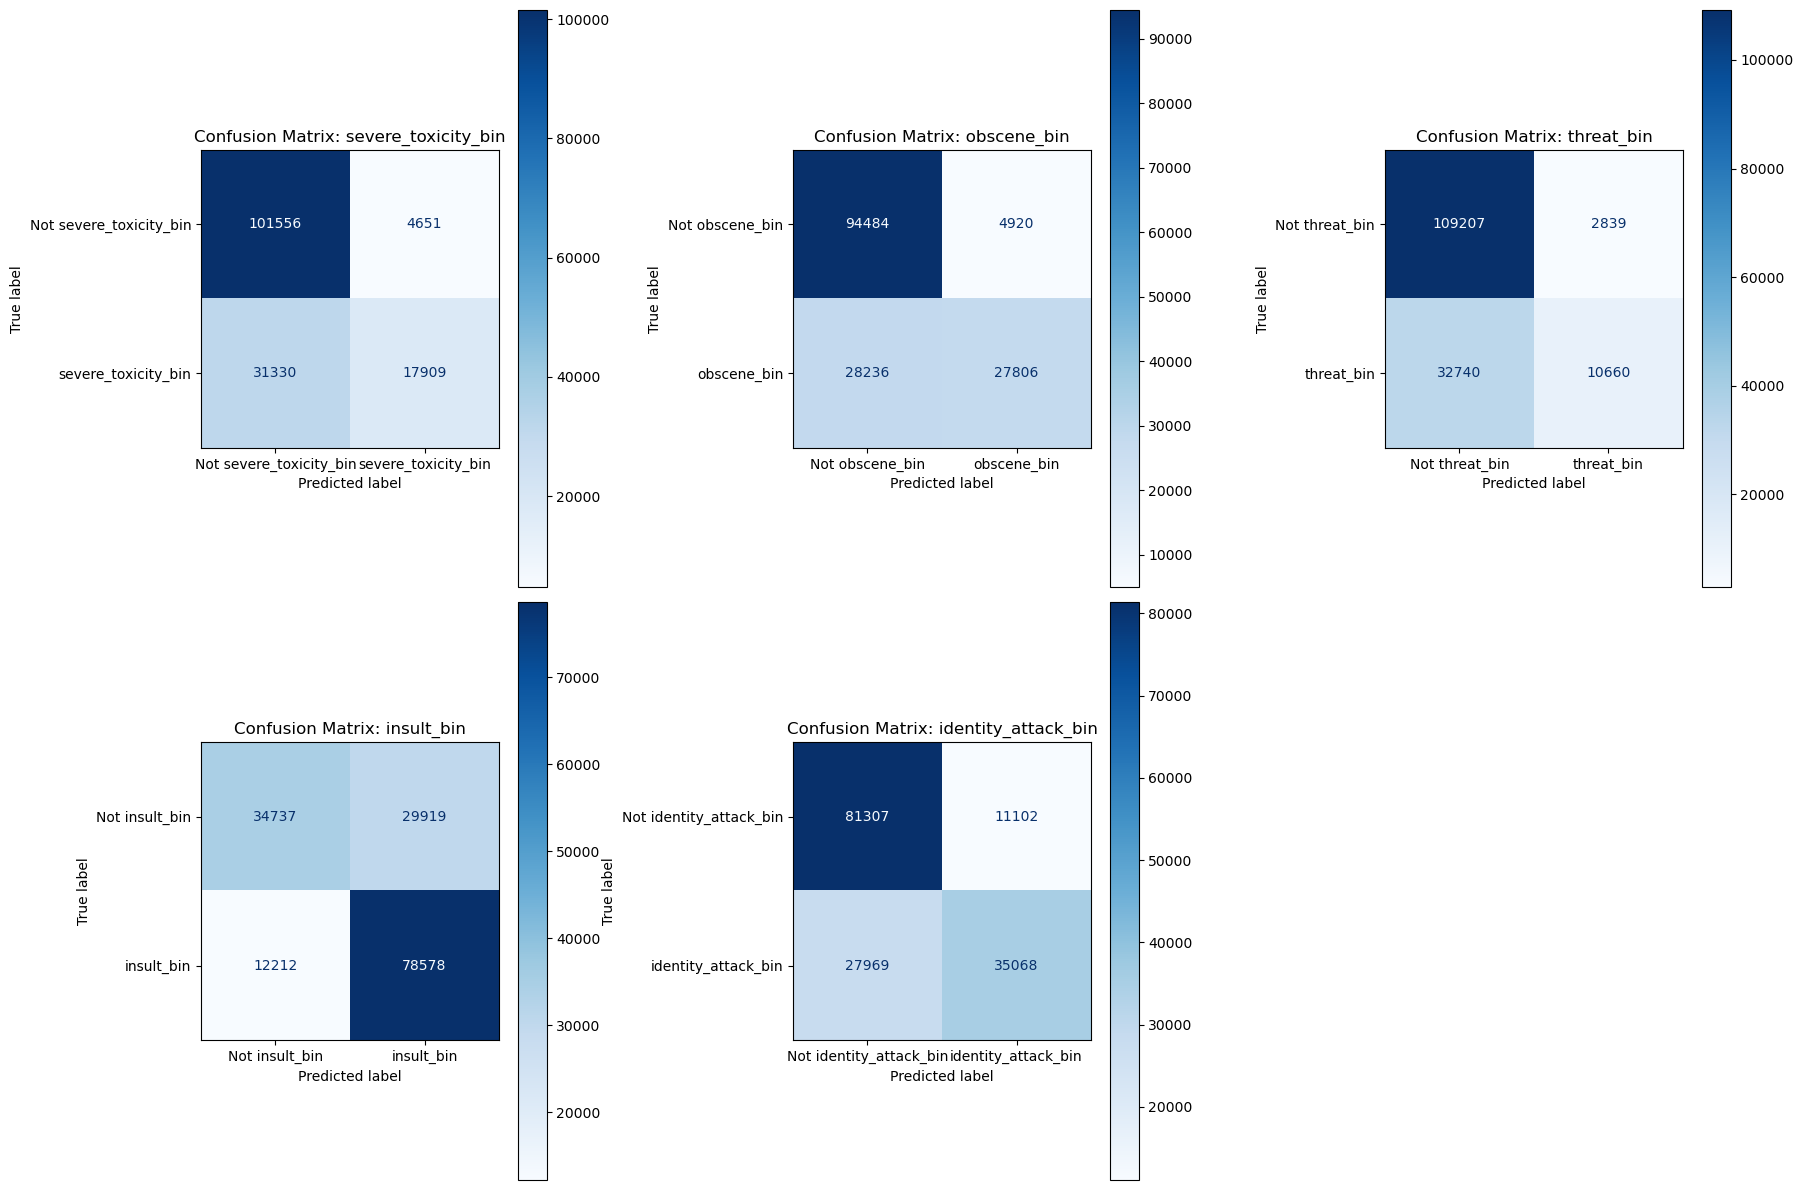

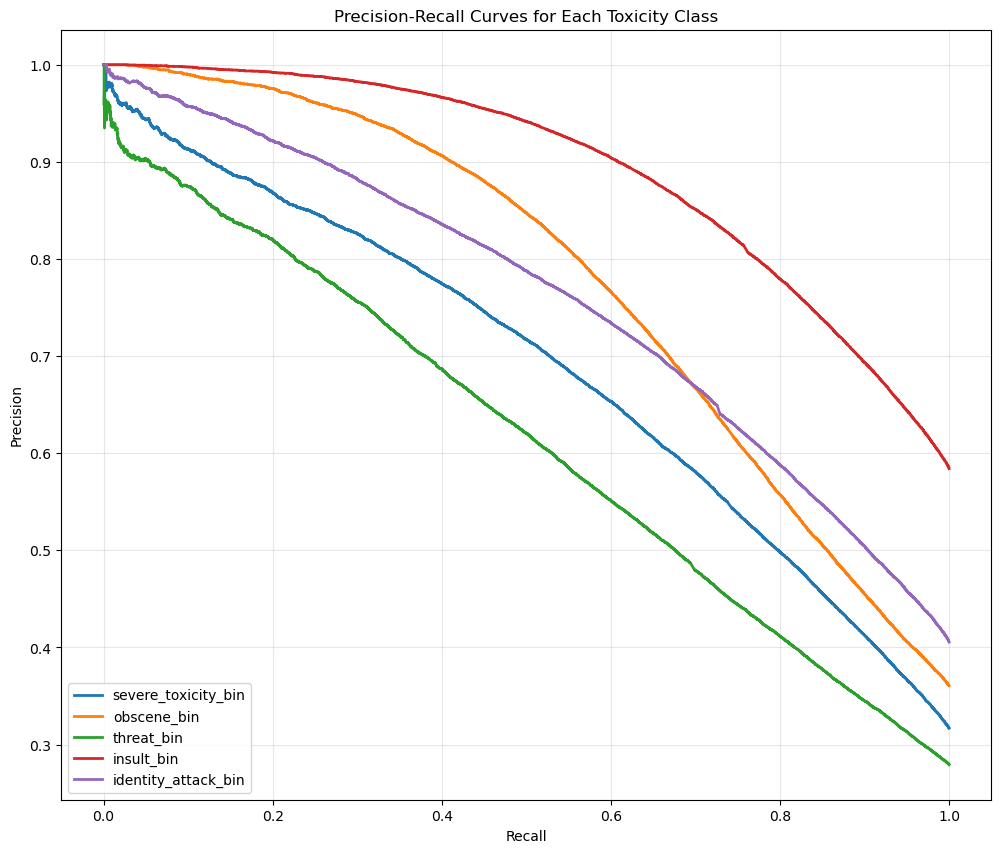


PERFORMANCE SUMMARY BY CLASS

severe_toxicity_bin:
  Accuracy: 0.7685
  Precision: 0.7938
  Recall: 0.3637
  F1-Score: 0.4989
  True Positives: 17909
  False Positives: 4651
  True Negatives: 101556
  False Negatives: 31330

obscene_bin:
  Accuracy: 0.7867
  Precision: 0.8497
  Recall: 0.4962
  F1-Score: 0.6265
  True Positives: 27806
  False Positives: 4920
  True Negatives: 94484
  False Negatives: 28236

threat_bin:
  Accuracy: 0.7711
  Precision: 0.7897
  Recall: 0.2456
  F1-Score: 0.3747
  True Positives: 10660
  False Positives: 2839
  True Negatives: 109207
  False Negatives: 32740

insult_bin:
  Accuracy: 0.7290
  Precision: 0.7242
  Recall: 0.8655
  F1-Score: 0.7886
  True Positives: 78578
  False Positives: 29919
  True Negatives: 34737
  False Negatives: 12212

identity_attack_bin:
  Accuracy: 0.7487
  Precision: 0.7595
  Recall: 0.5563
  F1-Score: 0.6422
  True Positives: 35068
  False Positives: 11102
  True Negatives: 81307
  False Negatives: 27969
✅ Model and vectorizer

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (classification_report, accuracy_score, roc_auc_score, 
                             roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
                             precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib



# Load the dataset
df = pd.read_csv("train.csv")

# 1. Create Correct Multi-Label Targets
# ----------------------------------------------------------------------------
toxicity_columns = ['severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack']
for col in toxicity_columns:
    df[col + '_bin'] = (df[col] > 0).astype(int)

target_labels = ['severe_toxicity_bin', 'obscene_bin', 'threat_bin', 'insult_bin', 'identity_attack_bin']
y = df[target_labels]

# 2. Create a "Master" Toxic Indicator
# ------------------------------------
df['is_toxic'] = (y.sum(axis=1) > 0).astype(int)
print("Original Dataset Balance:")
print(f"Non-Toxic comments: {(df['is_toxic'] == 0).sum()}")
print(f"Toxic comments: {(df['is_toxic'] == 1).sum()}\n")

# 3. Strategic Sampling to Balance the Dataset
# --------------------------------------------
df_non_toxic = df[df['is_toxic'] == 0]
df_toxic = df[df['is_toxic'] == 1]

# A. Undersample Non-Toxic
non_toxic_sample_ratio = 0.2
df_non_toxic_sampled = df_non_toxic.sample(frac=non_toxic_sample_ratio, random_state=42)

# B. Oversample Rare Toxic Types
toxic_counts = df_toxic[target_labels].sum()
rarest_toxic_type = toxic_counts.idxmin()
rarest_count = toxic_counts.min()

print("Toxic Subtype Counts (Before Oversampling):")
print(toxic_counts)
print(f"\nRarest type is '{rarest_toxic_type}' with {rarest_count} samples.\n")

# For each toxic subtype, oversample its examples
dfs_to_oversample = []
for label in target_labels:
    df_label = df_toxic[df_toxic[label] == 1].copy()
    current_count = len(df_label)
    
    n_samples_needed = rarest_count
    
    if current_count < n_samples_needed:
        df_label_oversampled = df_label.sample(n=n_samples_needed, replace=True, random_state=42)
        dfs_to_oversample.append(df_label_oversampled)
    else:
        dfs_to_oversample.append(df_label.sample(n=n_samples_needed, random_state=42))

# Combine all the oversampled toxic class DataFrames
df_toxic_oversampled = pd.concat(dfs_to_oversample)

# C. Create the Final Balanced Dataset
df_balanced = pd.concat([df_non_toxic_sampled, df_toxic_oversampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced Dataset Composition:")
print(f"Total samples: {len(df_balanced)}")
print(f"Non-Toxic samples: {len(df_balanced[df_balanced['is_toxic'] == 0])}")
print(f"Toxic samples: {len(df_balanced[df_balanced['is_toxic'] == 1])}\n")

# 4. Prepare Features and Target for the Balanced Dataset
# ------------------------------------------------------
X_balanced = df_balanced['comment_text'].fillna("")
y_balanced = df_balanced[target_labels]

# Vectorize the text
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(X_balanced)

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_balanced, test_size=0.2, random_state=42)

# 6. Train the Naive Bayes Model
# ------------------------------
model = MultinomialNB()
clf = OneVsRestClassifier(model)
clf.fit(X_train, y_train)

# 7. Comprehensive Evaluation
# ---------------------------
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

print("="*50)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*50)

# A. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# B. ROC AUC Scores
try:
    roc_auc_micro = roc_auc_score(y_test, y_pred_proba, average='micro', multi_class='ovr')
    roc_auc_macro = roc_auc_score(y_test, y_pred_proba, average='macro', multi_class='ovr')
    print(f"ROC AUC (micro): {roc_auc_micro:.4f}")
    print(f"ROC AUC (macro): {roc_auc_macro:.4f}")
except Exception as e:
    print(f"ROC AUC calculation warning: {e}")
    # Calculate ROC AUC for each class separately
    roc_auc_scores = {}
    for i, label in enumerate(target_labels):
        try:
            auc_score = roc_auc_score(y_test.iloc[:, i], y_pred_proba[:, i])
            roc_auc_scores[label] = auc_score
        except:
            roc_auc_scores[label] = 'N/A'
    print("ROC AUC per class:", roc_auc_scores)

# C. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_labels, zero_division=0))

# D. ROC Curves
plt.figure(figsize=(12, 10))
for i, label in enumerate(target_labels):
    fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Toxicity Class')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# E. Confusion Matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, label in enumerate(target_labels):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {label}', label])
    disp.plot(ax=axes[i], cmap='Blues', values_format='d')
    axes[i].set_title(f'Confusion Matrix: {label}')
    
# Remove empty subplot if we have odd number of classes
if len(target_labels) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

# F. Precision-Recall Tradeoff (Additional Insight)
plt.figure(figsize=(12, 10))
for i, label in enumerate(target_labels):
    precision, recall, _ = precision_recall_curve(y_test.iloc[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, lw=2, label=f'{label}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Toxicity Class')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

# G. Performance Summary by Class
print("\n" + "="*50)
print("PERFORMANCE SUMMARY BY CLASS")
print("="*50)
for i, label in enumerate(target_labels):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    tn, fp, fn, tp = cm.ravel()
    
    accuracy_class = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n{label}:")
    print(f"  Accuracy: {accuracy_class:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  True Positives: {tp}")
    print(f"  False Positives: {fp}")
    print(f"  True Negatives: {tn}")
    print(f"  False Negatives: {fn}")

# Save model and vectorizer for inference
joblib.dump(clf, "models/naive_bayes_model.pkl")
joblib.dump(vectorizer, "models/vectorizer.pkl")
print("✅ Model and vectorizer saved!")